# Predicting Mental Health Needs of Tech Employees
### Harsita Keerthikanth & Thy Tran
Dataset source: https://www.kaggle.com/datasets/osmi/mental-health-in-tech-survey/data


In [1]:
!pip install imblearn
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler, SMOTE
from collections import Counter
from sklearn.decomposition import PCA

from sklearn.model_selection import train_test_split, StratifiedKFold, KFold
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, log_loss
from sklearn.ensemble import RandomForestClassifier
import tensorflow as tf
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Dropout
from tensorflow.keras.optimizers import Adam
from imblearn.over_sampling import RandomOverSampler

In [2]:
# mount google drive to access files
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Dataset

In [3]:
# determine file path of necessary dataset
file_path = "/content/drive/My Drive/CS 131 - Final Project/not_normalized.csv"
df = pd.read_csv(file_path)

In [4]:
# basic structure of dataset after linux processing
print("Shape of dataset:", df.shape)
print("\nColumn names:\n", df.columns.tolist())
print("\nData types:\n", df.dtypes)
print("\nFirst 5 rows:\n", df.head())

Shape of dataset: (1246, 23)

Column names:
 ['Age', 'Gender', 'self_employed', 'family_history', 'treatment', 'work_interfere', 'no_employees', 'remote_work', 'tech_company', 'benefits', 'care_options', 'wellness_program', 'seek_help', 'anonymity', 'leave', 'mental_health_consequence', 'phys_health_consequence', 'coworkers', 'supervisor', 'mental_health_interview', 'phys_health_interview', 'mental_vs_physical', 'obs_consequence']

Data types:
 Age                          int64
Gender                       int64
self_employed                int64
family_history               int64
treatment                    int64
work_interfere               int64
no_employees                 int64
remote_work                  int64
tech_company                 int64
benefits                     int64
care_options                 int64
wellness_program             int64
seek_help                    int64
anonymity                    int64
leave                        int64
mental_health_consequence 

In [5]:
# summary statistics
print("\nSummary statistics:\n", df.describe(include='all'))


Summary statistics:
                Age       Gender  self_employed  family_history    treatment  \
count  1246.000000  1246.000000    1246.000000     1246.000000  1246.000000   
mean     32.087480     0.837079       0.113162        0.390851     0.504815   
std       7.297327     0.444445       0.316918        0.488137     0.500178   
min      18.000000     0.000000       0.000000        0.000000     0.000000   
25%      27.000000     1.000000       0.000000        0.000000     0.000000   
50%      31.000000     1.000000       0.000000        0.000000     1.000000   
75%      36.000000     1.000000       0.000000        1.000000     1.000000   
max      72.000000     2.000000       1.000000        1.000000     1.000000   

       work_interfere  no_employees  remote_work  tech_company     benefits  \
count     1246.000000   1246.000000  1246.000000   1246.000000  1246.000000   
mean         2.291332      2.431782     0.297753      0.820225     1.053772   
std          1.596494      1.

In [6]:
# missing values
print("\nMissing values per column:\n", df.isnull().sum())


Missing values per column:
 Age                          0
Gender                       0
self_employed                0
family_history               0
treatment                    0
work_interfere               0
no_employees                 0
remote_work                  0
tech_company                 0
benefits                     0
care_options                 0
wellness_program             0
seek_help                    0
anonymity                    0
leave                        0
mental_health_consequence    0
phys_health_consequence      0
coworkers                    0
supervisor                   0
mental_health_interview      0
phys_health_interview        0
mental_vs_physical           0
obs_consequence              0
dtype: int64


## Exploratory Data Analysis and Plots

<ipython-input-7-4b0beb6e4b5b>:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df["Age"], bins=24)


Text(0.5, 0, 'Age')

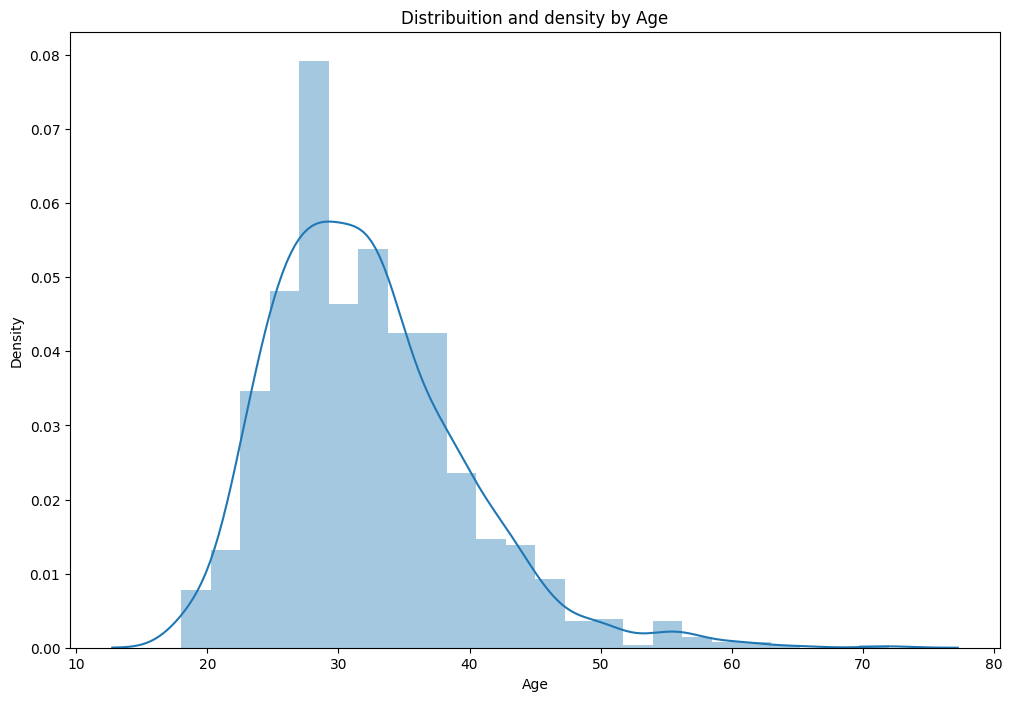

In [7]:
# plot: distribution and density by age
plt.figure(figsize=(12,8))
sns.distplot(df["Age"], bins=24)
plt.title("Distribuition and density by Age")
plt.xlabel("Age")

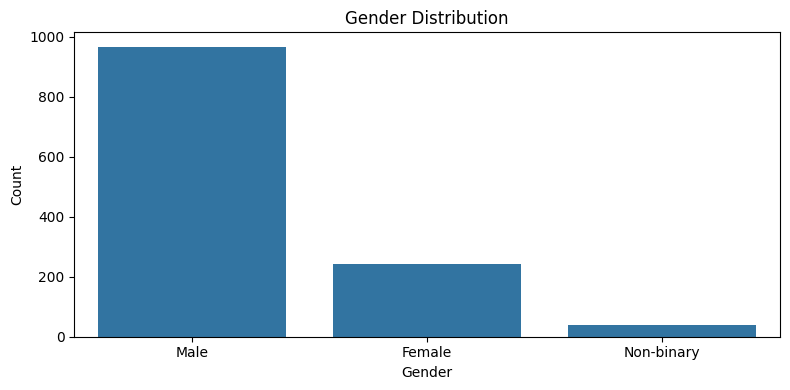

In [8]:
# plot: count of responses by gender (if gender is present)
# map gender numeric codes to labels
gender_map = {
    1: 'Male',
    0: 'Female',
    2: 'Non-binary'
}

# replace values with proper labels
df['gender_labeled'] = df['Gender'].map(gender_map)

# plot labeled gender counts
plt.figure(figsize=(8, 4))
sns.countplot(data=df, x='gender_labeled', order=df['gender_labeled'].value_counts().index)
plt.title("Gender Distribution")
plt.xlabel("Gender")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

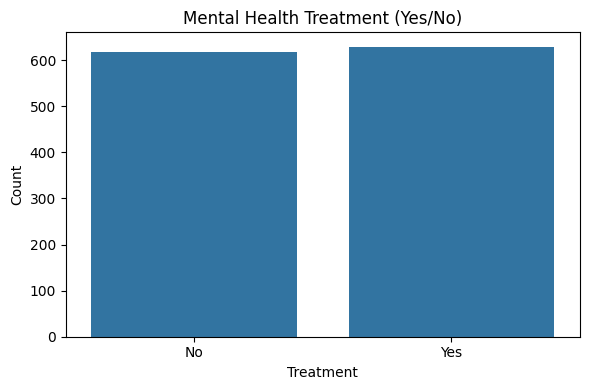

In [9]:
# plot: mental health treatment yes/no distribution
# map treatment numeric codes to labels
treatment_map = {
    0.0: 'No',
    1.0: 'Yes'
}

# apply the mapping to a new column
df['treatment_labeled'] = df['treatment'].map(treatment_map)

# plot labeled treatment data
if 'treatment_labeled' in df.columns:
    plt.figure(figsize=(6, 4))
    sns.countplot(data=df, x='treatment_labeled', order=['No', 'Yes'])
    plt.title("Mental Health Treatment (Yes/No)")
    plt.xlabel("Treatment")
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()

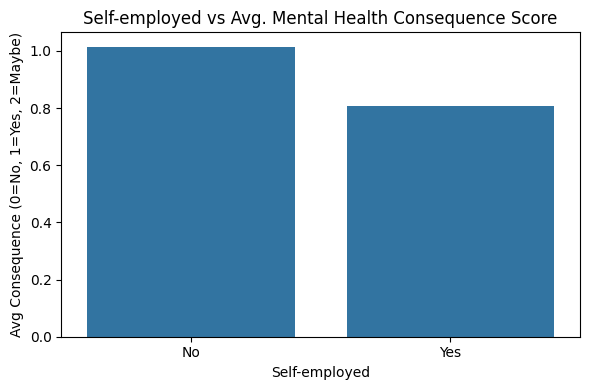

In [10]:
# plot: comparison of self employed vs mental health consequence
# map values for self_employed and mental_health_consequence
self_employed_map = {
    0.0: 'No',
    1.0: 'Yes'
}

consequence_map = {
    0.0: 'No',
    0.5: 'Yes',
    1.0: 'Maybe'
}

# apply mapping to new labeled columns
df['self_employed_labeled'] = df['self_employed'].map(self_employed_map)
df['consequence_labeled'] = df['mental_health_consequence'].map(consequence_map)

# group and get average consequence score for each self-employed group
grouped = df.groupby('self_employed_labeled')['mental_health_consequence'].mean().reset_index()

# plot
plt.figure(figsize=(6, 4))
sns.barplot(data=grouped, x='self_employed_labeled', y='mental_health_consequence')
plt.title("Self-employed vs Avg. Mental Health Consequence Score")
plt.xlabel("Self-employed")
plt.ylabel("Avg Consequence (0=No, 1=Yes, 2=Maybe)")
plt.tight_layout()
plt.show()

/usr/local/lib/python3.11/dist-packages/seaborn/axisgrid.py:854: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  func(*plot_args, **plot_kwargs)
/usr/local/lib/python3.11/dist-packages/seaborn/axisgrid.py:854: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  func(*plot_args, **plot_kwargs)


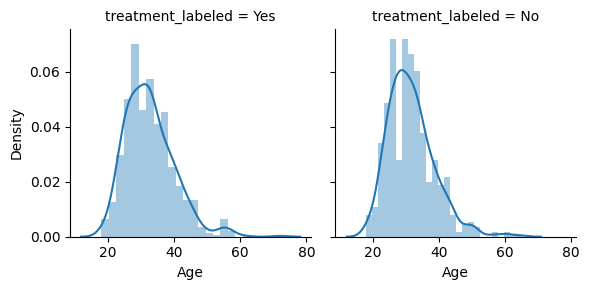

In [11]:
# plot: treatment yes/no density by age
g = sns.FacetGrid(df, col='treatment_labeled')
g = g.map(sns.distplot, "Age")

<ipython-input-12-a195b936a081>:20: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  g = sns.catplot(


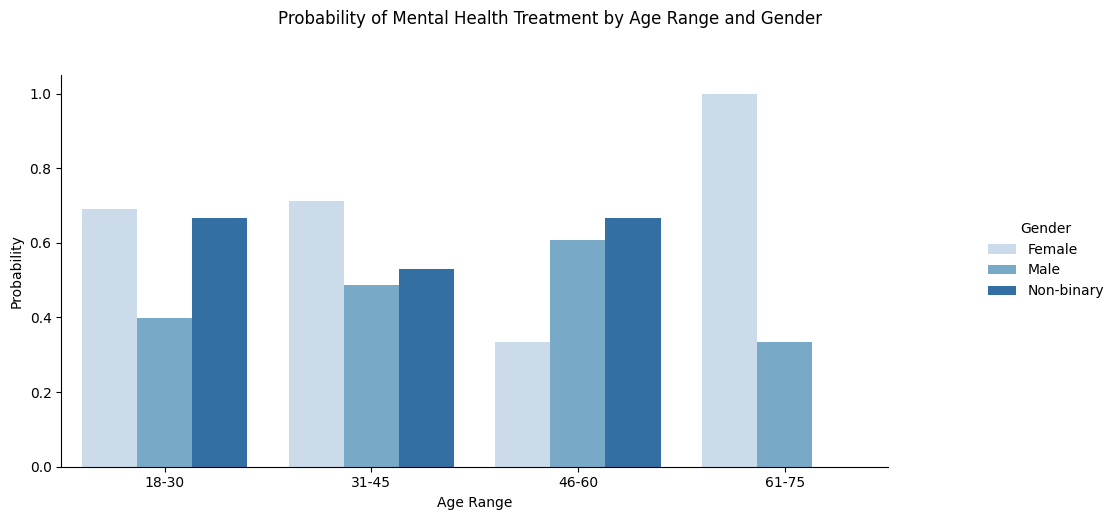

In [12]:
# plot: probability of treatment by age range and gender

# blue color palette
palette = sns.color_palette("Blues", n_colors=df['Gender'].nunique())

# group age into categories
df['age_range'] = pd.cut(
    df['Age'],
    bins=[17, 30, 45, 60, 75],  # covers 18–72 range
    labels=["18-30", "31-45", "46-60", "61-75"]
)

# define mapping dictionary
gender_mapping = {1: 'Male', 0: 'Female', 2: 'Non-binary'}

# apply mapping to create a new column with labels
df['gender_label'] = df['Gender'].map(gender_mapping)

# plot
g = sns.catplot(
    x="age_range",
    y="treatment",
    hue="gender_label",
    data=df,
    kind="bar",
    ci=None,
    height=5,
    aspect=2,
    legend_out=True,
    palette=palette
)

# set axis labels and title
g._legend.set_title("Gender")
g.set_axis_labels("Age Range", "Probability")
g.fig.suptitle("Probability of Mental Health Treatment by Age Range and Gender", y=1.03)

# adjust layout for legend
g.fig.subplots_adjust(top=0.9, right=0.8)

# show plot
plt.show()

<ipython-input-13-7044a3cc56c1>:13: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  g = sns.catplot(


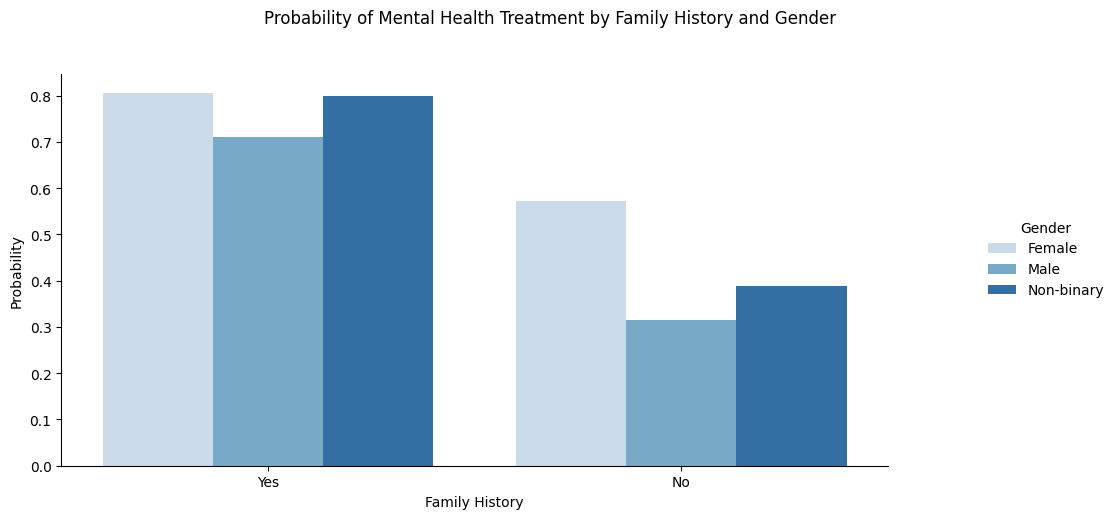

In [13]:
# plot: probability of treatment by family history and gender

# blue color palette
palette = sns.color_palette("Blues", n_colors=df['Gender'].nunique())

# define mapping dictionary
family_history_mapping = {1: 'Yes', 0: 'No'}

# apply mapping to create a new column with labels
df['family_history_label'] = df['family_history'].map(family_history_mapping)

# plot
g = sns.catplot(
    x="family_history_label",
    y="treatment",
    hue="gender_label",
    data=df,
    kind="bar",
    ci=None,
    height=5,
    aspect=2,
    legend_out=True,
    palette=palette
)

# set axis labels and title
g._legend.set_title("Gender")
g.set_axis_labels("Family History", "Probability")
g.fig.suptitle("Probability of Mental Health Treatment by Family History and Gender", y=1.03)

# adjust layout for legend
g.fig.subplots_adjust(top=0.9, right=0.8)

# show plot
plt.show()


<ipython-input-14-d16ea096f938>:13: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  g = sns.catplot(


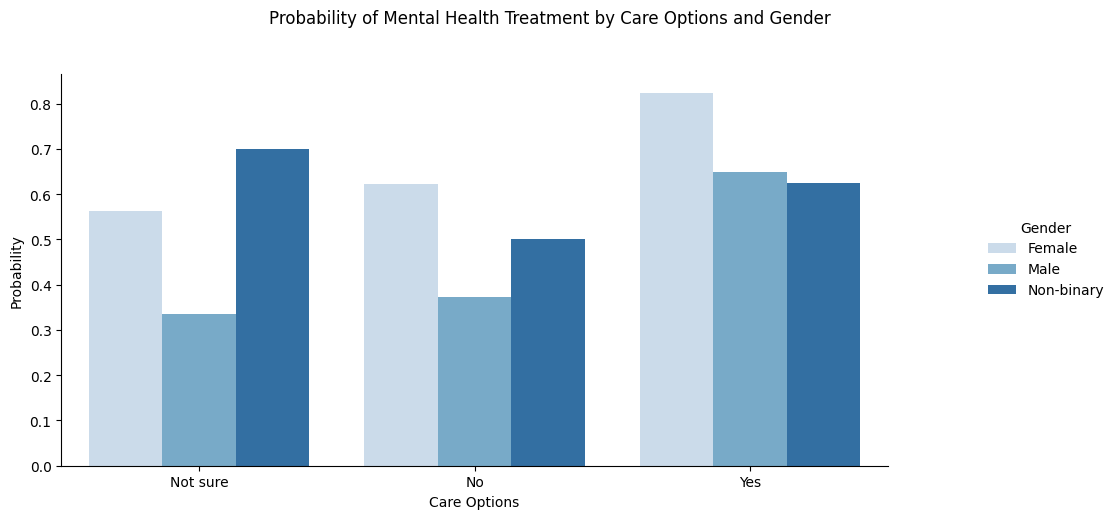

In [14]:
# plot: probability of mental health treatment by care options and gender

# blue color palette
palette = sns.color_palette("Blues", n_colors=df['Gender'].nunique())

# define mapping dictionary
care_options_mapping = {1: 'Yes', 0: 'No', 2: 'Not sure'}

# apply mapping to create a new column with labels
df['care_options_label'] = df['care_options'].map(care_options_mapping)

# plot
g = sns.catplot(
    x="care_options_label",
    y="treatment",
    hue="gender_label",
    data=df,
    kind="bar",
    ci=None,
    height=5,
    aspect=2,
    legend_out=True,
    palette=palette
)

# set axis labels and title
g._legend.set_title("Gender")
g.set_axis_labels("Care Options", "Probability")
g.fig.suptitle("Probability of Mental Health Treatment by Care Options and Gender", y=1.03)

# adjust legend sizing
g.fig.subplots_adjust(top=0.9, right=0.8)

# show plot
plt.show()

<ipython-input-15-c80e1eb2611f>:12: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  g = sns.catplot(


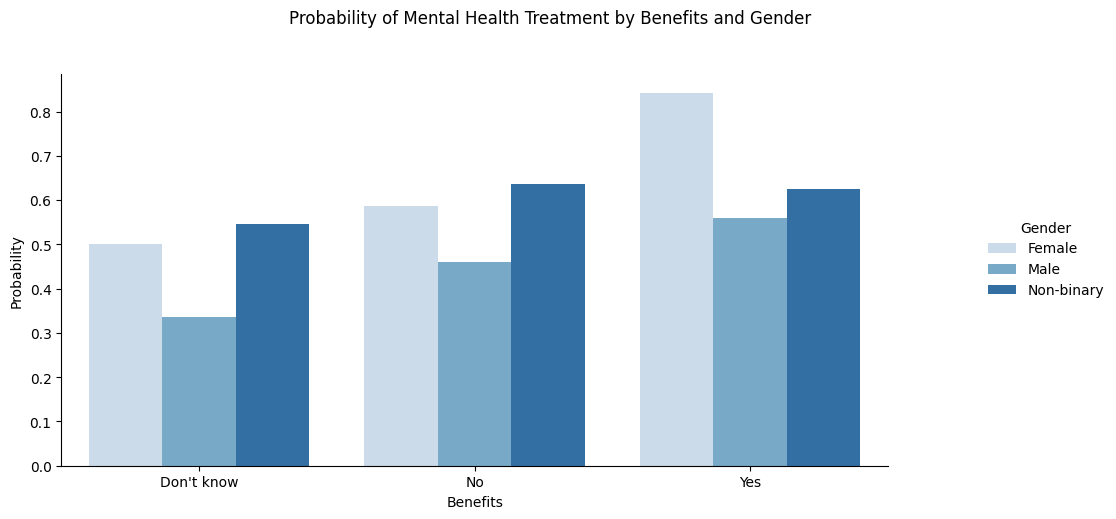

In [15]:
# plot: probability of mental health treatment by benefits and gender
# blue color palette
palette = sns.color_palette("Blues", n_colors=df['Gender'].nunique())

# define mapping dictionary
benefits_mapping = {1: 'No', 0: "Don't know", 2: 'Yes'}

# apply mapping to create a new column with labels
df['benefits_label'] = df['benefits'].map(benefits_mapping)

# plot
g = sns.catplot(
    x="benefits_label",
    y="treatment",
    hue="gender_label",
    data=df,
    kind="bar",
    ci=None,
    height=5,
    aspect=2,
    legend_out=True,
    palette=palette
)

# set axis labels and title
g._legend.set_title("Gender")
g.set_axis_labels("Benefits", "Probability")
g.fig.suptitle("Probability of Mental Health Treatment by Benefits and Gender", y=1.03)

# adjust layout for legend
g.fig.subplots_adjust(top=0.9, right=0.8)

# show plot
plt.show()

<ipython-input-16-b08c97a94920>:19: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  g = sns.catplot(


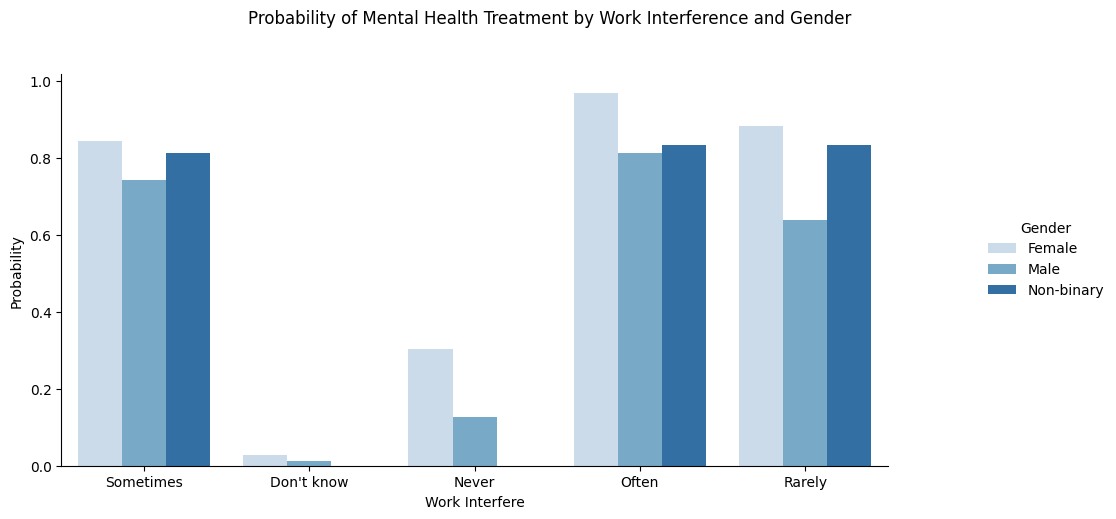

In [16]:
# plot: probability of mental health treatment by work interference and gender

# blue color palette
palette = sns.color_palette("Blues", n_colors=df['Gender'].nunique())

# define mapping dictionary
work_interfere_mapping = {
    0: "Don't know",
    1: "Never",
    2: "Often",
    3: "Rarely",
    4: "Sometimes"
}

# apply mapping to create a new column with labels
df['work_interfere_label'] = df['work_interfere'].map(work_interfere_mapping)

# plot
g = sns.catplot(
    x="work_interfere_label",
    y="treatment",
    hue="gender_label",
    data=df,
    kind="bar",
    ci=None,
    height=5,
    aspect=2,
    legend_out=True,
    palette=palette
)

# set axis labels and title
g._legend.set_title("Gender")
g.set_axis_labels("Work Interfere", "Probability")
g.fig.suptitle("Probability of Mental Health Treatment by Work Interference and Gender", y=1.03)

# adjust legend sizing and layout
g.fig.subplots_adjust(top=0.9, right=0.8)

# show plot
plt.show()


## Sampling Techniques

In [17]:
# total number of rows (excluding header)
print("Total rows:", len(df))

# count of each unique value in a column (e.g., 'gender')
print(df['treatment'].value_counts())

Total rows: 1246
treatment
1    629
0    617
Name: count, dtype: int64


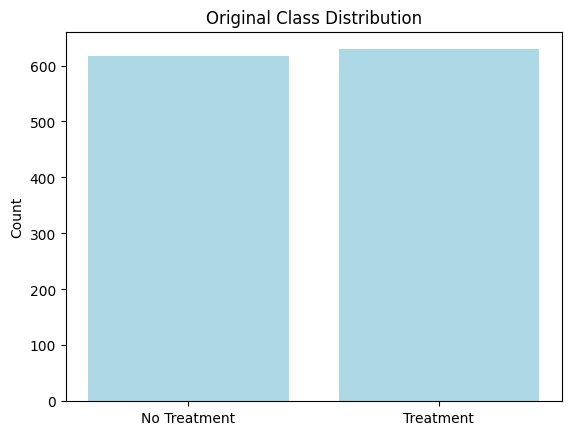

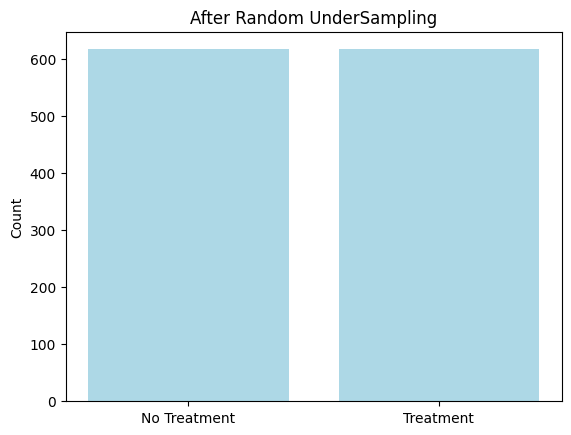

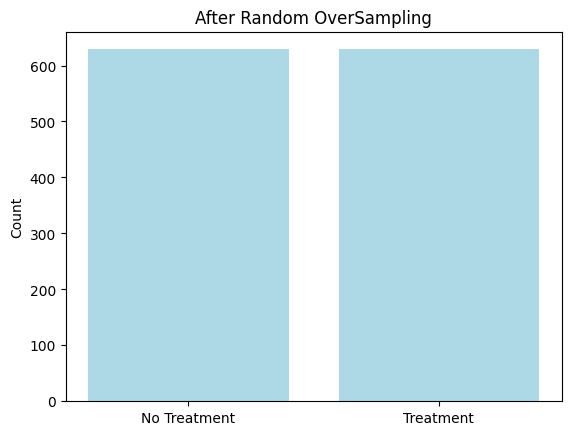

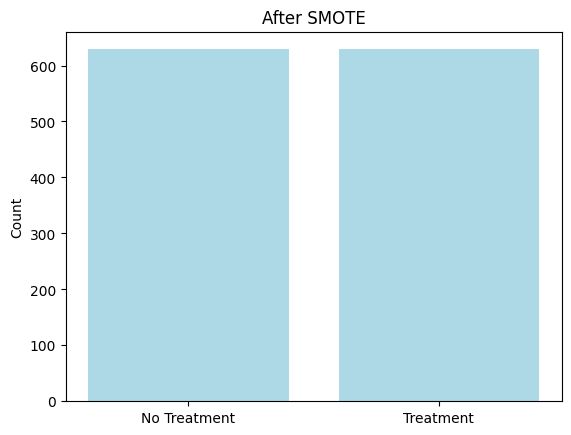

In [18]:
# load cleaned dataset from drive
file_path = "/content/drive/My Drive/CS 131 - Final Project/clean.csv"
df = pd.read_csv(file_path)

# split dataset into features (X) and target (y)
X = df.drop('treatment', axis=1)
y = df['treatment']

# helper function to visualize class distribution
def plot_class_distribution(title, y_values):
    count = Counter(y_values) # count occurances of each class
    plt.bar(count.keys(), count.values(), color='#ADD8E6')  # bar plot
    plt.title(title)
    plt.xticks([0, 1], ['No Treatment', 'Treatment']) # label classes
    plt.ylabel("Count")
    plt.show()

# plot original class distribution before resampling
plot_class_distribution("Original Class Distribution", y)

# 1. random undersampling - reduce majority class by randomly removing samples
rus = RandomUnderSampler(random_state=42)
X_rus, y_rus = rus.fit_resample(X, y)
plot_class_distribution("After Random UnderSampling", y_rus)

# 2. random oversampling - increase minority class by randomly duplicating samples
ros = RandomOverSampler(random_state=42)
X_ros, y_ros = ros.fit_resample(X, y)
plot_class_distribution("After Random OverSampling", y_ros)

# 3. SMOTE - generate synthetic examples for minority class
sm = SMOTE(random_state=42)
X_sm, y_sm = sm.fit_resample(X, y)
plot_class_distribution("After SMOTE", y_sm)

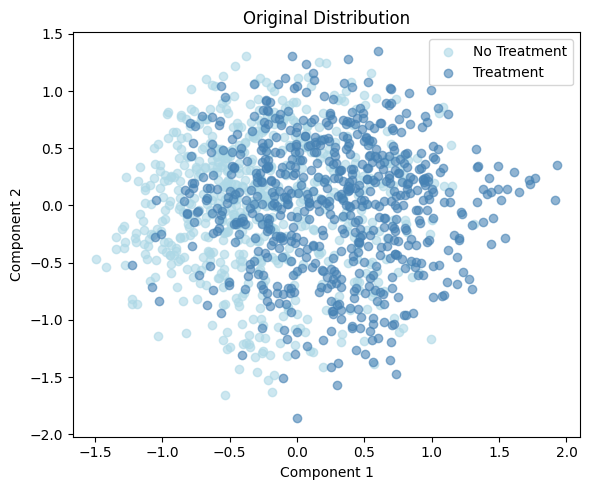

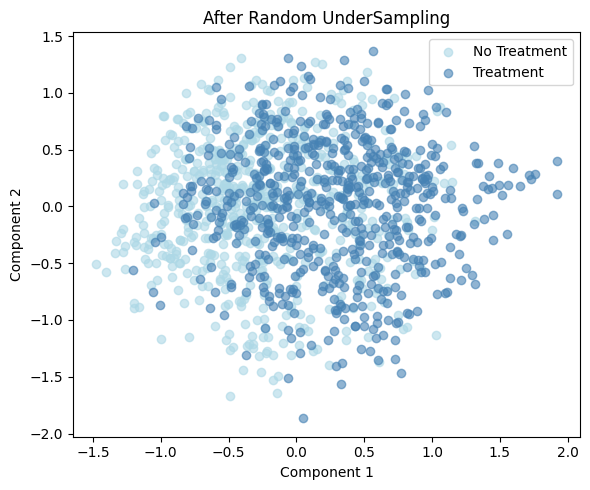

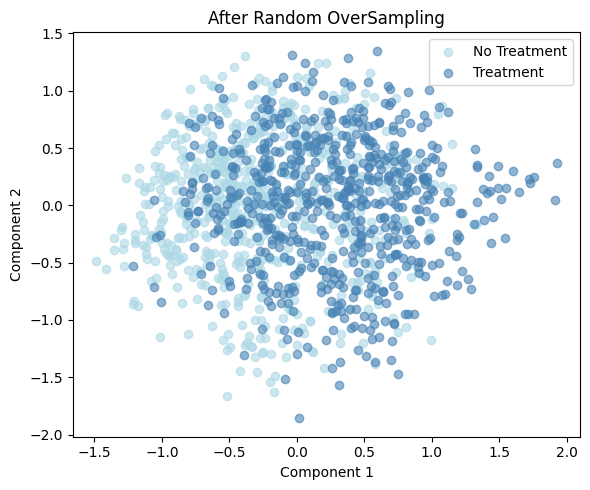

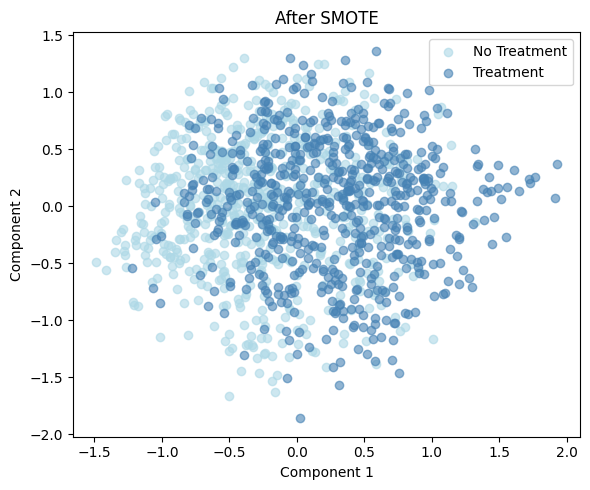

In [19]:
# load cleaned dataset from drive
file_path = "/content/drive/My Drive/CS 131 - Final Project/clean.csv"
df = pd.read_csv(file_path)

# split dataset into features and target
X = df.drop('treatment', axis=1)
y = df['treatment']

# helper function to perform PCA and reduce dimensionality to 2 components for visualization
def reduce_dimensions(X):
    pca = PCA(n_components=2, random_state=42)
    return pca.fit_transform(X)

# helper function for scatterplot
def plot_scatter(title, X_proj, y_values):
    plt.figure(figsize=(6, 5))
    plt.scatter(X_proj[y_values == 0][:, 0], X_proj[y_values == 0][:, 1],
                alpha=0.6, c='#ADD8E6', label='No Treatment')
    plt.scatter(X_proj[y_values == 1][:, 0], X_proj[y_values == 1][:, 1],
                alpha=0.6, c='#4682B4', label='Treatment')
    plt.title(title)
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")
    plt.legend()
    plt.tight_layout()
    plt.show()

# plot original class distribution before resampling
X_proj = reduce_dimensions(X)
plot_scatter("Original Distribution", X_proj, y)

# 1. random undersampling - reduce majority class by randomly removing samples
rus = RandomUnderSampler(random_state=42)
X_rus, y_rus = rus.fit_resample(X, y)
X_rus_proj = reduce_dimensions(X_rus)
plot_scatter("After Random UnderSampling", X_rus_proj, y_rus)

# 2. random oversampling - increase minority class by randomly duplicating samples
ros = RandomOverSampler(random_state=42)
X_ros, y_ros = ros.fit_resample(X, y)
X_ros_proj = reduce_dimensions(X_ros)
plot_scatter("After Random OverSampling", X_ros_proj, y_ros)

# 3. SMOTE - generate synthetic examples for minority class
sm = SMOTE(random_state=42)
X_sm, y_sm = sm.fit_resample(X, y)
X_sm_proj = reduce_dimensions(X_sm)
plot_scatter("After SMOTE", X_sm_proj, y_sm)


## ML Model: Logistic Regression


 Best Hyperparameters:
{'learning_rate': 0.001, 'max_iter': 100}

 Training Metrics:
Accuracy : 0.7961
Precision: 0.7734
Recall   : 0.8377
F1 Score : 0.8043

 Test Metrics:
Accuracy : 0.8080
Precision: 0.8197
Recall   : 0.7937
F1 Score : 0.8065

 Simulating Loss Curve...


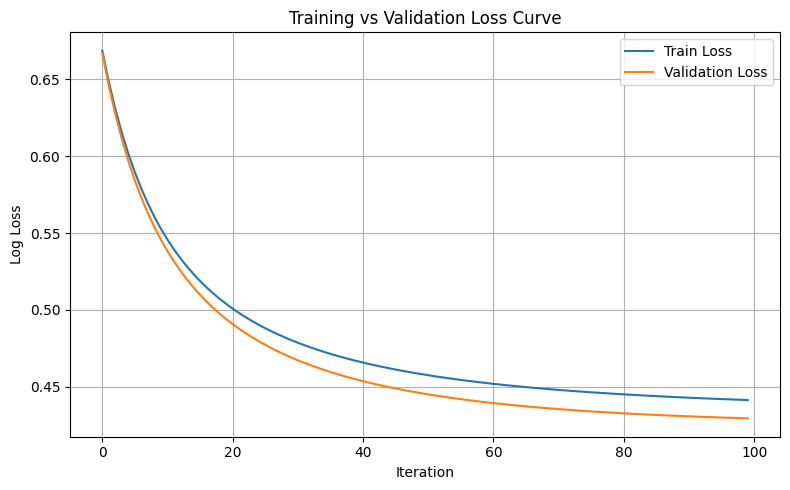

In [20]:
# load cleaned dataset and extract features and target
file_path = "/content/drive/My Drive/CS 131 - Final Project/clean.csv"
df = pd.read_csv(file_path)
X = df.drop('treatment', axis=1).values
y = df['treatment'].values

# choose a sampling technique (uncomment)
# sampler = SMOTE(random_state=42)
# sampler = RandomOverSampler(random_state=42)
sampler = RandomUnderSampler(random_state=42) # using undersampling for this run

# define hyperparameter ranges
learning_rates = [0.1, 0.001, 0.0001]
max_iters = [100, 500, 1000]

# initialize stratified 5-fold cross validation
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# variables to store the best model's f1 score and parameters
best_f1 = 0
best_params = {}

# grid search using cross validation
for lr in learning_rates:
    for max_iter in max_iters:
        fold_f1s = [] # store f1 scores for each fold
        for train_idx, val_idx in kfold.split(X, y):
            # split data into training and validation folds
            X_train_fold, X_val_fold = X[train_idx], X[val_idx]
            y_train_fold, y_val_fold = y[train_idx], y[val_idx]

            # apply chosen resampling method to training fold
            X_sampled, y_sampled = sampler.fit_resample(X_train_fold, y_train_fold)

            # initialize and train sgd classifier with logistic loss
            model = SGDClassifier(loss='log_loss', learning_rate='constant',
                                  eta0=lr, max_iter=max_iter, tol=None, random_state=42)
            model.fit(X_sampled, y_sampled)
            y_pred = model.predict(X_val_fold)
            fold_f1s.append(f1_score(y_val_fold, y_pred))

        # calculate average f1 score across folds
        avg_f1 = np.mean(fold_f1s)

        # update best hyperparameters if current config performs better
        if avg_f1 > best_f1:
            best_f1 = avg_f1
            best_params = {'learning_rate': lr, 'max_iter': max_iter}

# final train test split for evaluation
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# apply resampling to training data
X_train_resampled, y_train_resampled = sampler.fit_resample(X_train, y_train)

# final model using best hyperparameters from grid search
final_model = SGDClassifier(
    loss='log_loss',
    learning_rate='constant',
    eta0=best_params['learning_rate'],
    max_iter=best_params['max_iter'],
    random_state=42
)
final_model.fit(X_train_resampled, y_train_resampled)

# evaluate model on resampled training data
y_train_pred = final_model.predict(X_train_resampled)
train_acc = accuracy_score(y_train_resampled, y_train_pred)
train_prec = precision_score(y_train_resampled, y_train_pred)
train_rec = recall_score(y_train_resampled, y_train_pred)
train_f1 = f1_score(y_train_resampled, y_train_pred)

# evaluate model on unseen test data
y_test_pred = final_model.predict(X_test)
test_acc = accuracy_score(y_test, y_test_pred)
test_prec = precision_score(y_test, y_test_pred)
test_rec = recall_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred)

# print optimal hyperparameters and metrics
print("\n Best Hyperparameters:")
print(best_params)

print("\n Training Metrics:")
print(f"Accuracy : {train_acc:.4f}")
print(f"Precision: {train_prec:.4f}")
print(f"Recall   : {train_rec:.4f}")
print(f"F1 Score : {train_f1:.4f}")

print("\n Test Metrics:")
print(f"Accuracy : {test_acc:.4f}")
print(f"Precision: {test_prec:.4f}")
print(f"Recall   : {test_rec:.4f}")
print(f"F1 Score : {test_f1:.4f}")

# simulate and visualize training vs validation loss curve across iterations
print("\n Simulating Loss Curve...")

# reinitialize model with 1 iteration per fit call for loss tracking
model = SGDClassifier(
    loss='log_loss',
    learning_rate='constant',
    eta0=best_params['learning_rate'],
    max_iter=1,
    tol=None,
    warm_start=True,
    random_state=42
)

# track training and validation loss
train_losses, val_losses = [], []

# loop over number of iterations to manually simulate epchs
for epoch in range(best_params['max_iter']):
    model.fit(X_train_resampled, y_train_resampled)
    train_losses.append(log_loss(y_train_resampled, model.predict_proba(X_train_resampled)))
    val_losses.append(log_loss(y_test, model.predict_proba(X_test)))

# plot loss curves
plt.figure(figsize=(8, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel("Iteration")
plt.ylabel("Log Loss")
plt.title("Training vs Validation Loss Curve")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## ML Model: Random Forest


Best Hyperparameter Combination:
  n_estimators: 50
  max_depth: 10
  min_samples_leaf: 4
  max_features: sqrt

Training Set Metrics:
  Accuracy : 0.8966
  Precision: 0.8582
  Recall   : 0.9503
  F1-Score : 0.9019

Test Set Metrics:
  Accuracy : 0.8600
  Precision: 0.8370
  Recall   : 0.8968
  F1-Score : 0.8659

Classification Report on Test Set:
              precision    recall  f1-score   support

No Treatment       0.89      0.82      0.85       124
   Treatment       0.84      0.90      0.87       126

    accuracy                           0.86       250
   macro avg       0.86      0.86      0.86       250
weighted avg       0.86      0.86      0.86       250


Simulating Log Loss Curve...


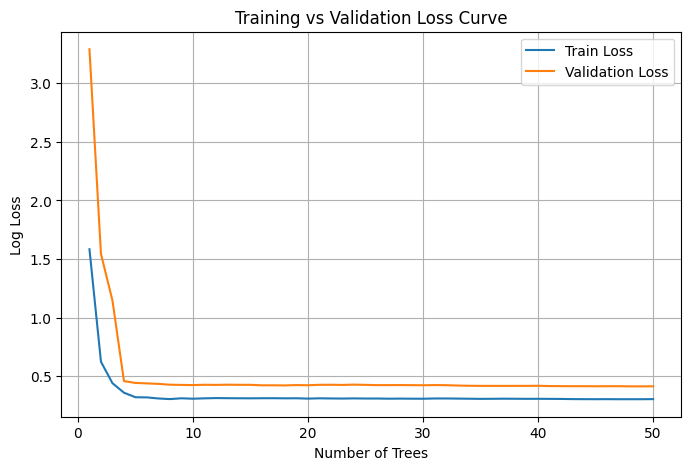

In [21]:
# load clean dataset and split into features and target
file_path = "/content/drive/My Drive/CS 131 - Final Project/clean.csv"
df = pd.read_csv(file_path)
X = df.drop('treatment', axis=1).values
y = df['treatment'].values

# define hyperparameters for grid search
n_estimators_list = [50, 100] # number of trees in the forest
max_depths = [10, 15, 20] # max depth of each tree
min_samples_leaf_list = [1, 2, 4] # min number of samples at a leaf node
max_features_list = ['sqrt']  # number of features to consider at each split

# 5 fold stratified cross validation
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# track best results
best_f1 = 0
best_params = {}

# grid search over all combinations of hyperparameters
for n_est in n_estimators_list:
    for max_depth in max_depths:
        for min_leaf in min_samples_leaf_list:
            for max_feat in max_features_list:
                fold_f1s = [] # store f1 scores for each fold

                # perform cross validation
                for train_idx, test_idx in kfold.split(X, y):
                    X_train, X_test = X[train_idx], X[test_idx]
                    y_train, y_test = y[train_idx], y[test_idx]

                    # apply smote
                    smote = SMOTE(random_state=42)
                    X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

                    # initialize and train random forest
                    model = RandomForestClassifier(
                        n_estimators=n_est,
                        max_depth=max_depth,
                        min_samples_leaf=min_leaf,
                        max_features=max_feat,
                        random_state=42,
                        n_jobs=-1
                    )
                    model.fit(X_train_resampled, y_train_resampled)

                    # evaluate model on validation fold
                    y_pred = model.predict(X_test)
                    fold_f1s.append(f1_score(y_test, y_pred))

                # calculate average f1 scores across 5 folds
                avg_f1 = np.mean(fold_f1s)

                # update best hyperparameters if needed
                if avg_f1 > best_f1:
                    best_f1 = avg_f1
                    best_params = {
                        'n_estimators': n_est,
                        'max_depth': max_depth,
                        'min_samples_leaf': min_leaf,
                        'max_features': max_feat
                    }

# print best hyperparameters
print("\nBest Hyperparameter Combination:")
for key, val in best_params.items():
    print(f"  {key}: {val}")

# final train/test split for evaluation
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# apply smote to full training set
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# train final model with best hyperparameters
final_model = RandomForestClassifier(
    n_estimators=best_params['n_estimators'],
    max_depth=best_params['max_depth'],
    min_samples_leaf=best_params['min_samples_leaf'],
    max_features=best_params['max_features'],
    random_state=42,
    n_jobs=-1
)
final_model.fit(X_train_resampled, y_train_resampled)

# generate predictions for both training and test sets
y_train_pred = final_model.predict(X_train_resampled)
y_test_pred = final_model.predict(X_test)

# evaluation metrics
print("\nTraining Set Metrics:")
print(f"  Accuracy : {accuracy_score(y_train_resampled, y_train_pred):.4f}")
print(f"  Precision: {precision_score(y_train_resampled, y_train_pred):.4f}")
print(f"  Recall   : {recall_score(y_train_resampled, y_train_pred):.4f}")
print(f"  F1-Score : {f1_score(y_train_resampled, y_train_pred):.4f}")

print("\nTest Set Metrics:")
print(f"  Accuracy : {accuracy_score(y_test, y_test_pred):.4f}")
print(f"  Precision: {precision_score(y_test, y_test_pred):.4f}")
print(f"  Recall   : {recall_score(y_test, y_test_pred):.4f}")
print(f"  F1-Score : {f1_score(y_test, y_test_pred):.4f}")

# classification report for test set
print("\nClassification Report on Test Set:")
print(classification_report(y_test, y_test_pred, target_names=["No Treatment", "Treatment"]))

# training vs validation log loss curve simulation
print("\nSimulating Log Loss Curve...")

train_losses, val_losses = [], []
tree_range = range(1, best_params['n_estimators'] + 1)

# incrementally increase number of trees and track performance
for n_trees in tree_range:
    model = RandomForestClassifier(
        n_estimators=n_trees,
        max_depth=best_params['max_depth'],
        min_samples_leaf=best_params['min_samples_leaf'],
        max_features=best_params['max_features'],
        random_state=42,
        n_jobs=-1
    )
    model.fit(X_train_resampled, y_train_resampled)

    # compute log loss for both training and test sets
    train_proba = model.predict_proba(X_train_resampled)
    val_proba = model.predict_proba(X_test)
    train_losses.append(log_loss(y_train_resampled, train_proba))
    val_losses.append(log_loss(y_test, val_proba))

# plot loss curve
plt.figure(figsize=(8, 5))
plt.plot(tree_range, train_losses, label='Train Loss')
plt.plot(tree_range, val_losses, label='Validation Loss')
plt.xlabel("Number of Trees")
plt.ylabel("Log Loss")
plt.title("Training vs Validation Loss Curve")
plt.legend()
plt.grid(True)
plt.show()


## Neural Network: Multi-Layer Perceptron

Fold: 1/5
Fold: 2/5
Fold: 3/5
Fold: 4/5
Fold: 5/5
Width=32, Depth=1 -- Train Loss=0.5285, Val Loss=0.5193

Fold: 1/5
Fold: 2/5
Fold: 3/5
Fold: 4/5
Fold: 5/5
Width=32, Depth=2 -- Train Loss=0.5127, Val Loss=0.4852

Fold: 1/5
Fold: 2/5
Fold: 3/5
Fold: 4/5
Fold: 5/5
Width=1024, Depth=1 -- Train Loss=0.3906, Val Loss=0.4472

Fold: 1/5
Fold: 2/5
Fold: 3/5
Fold: 4/5
Fold: 5/5
Width=1024, Depth=2 -- Train Loss=0.1418, Val Loss=0.5989

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 

 Best Hyperparameters:
Width: 1024, Depth: 1, Learning Rate: 0.0001

 Training Metrics:
Accuracy : 0.8250
Precision: 0.8000
Recall   : 0.8668
F1 Score : 0.8321

 Test Metrics:
Accuracy : 0.8120
Precision: 0.8110
Recall   : 0.8175
F1 Score : 0.8142


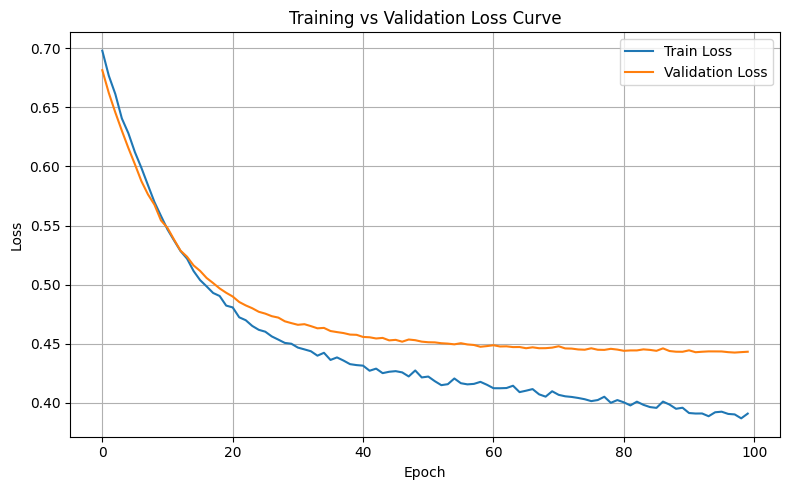

In [22]:
# load dataset and split into features/target
df = pd.read_csv("/content/drive/My Drive/CS 131 - Final Project/clean.csv")
X = df.drop('treatment', axis=1)
y = df['treatment']

# split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)

# apply random oversampling to balance training set
sampler = RandomOverSampler(random_state=42)
X_train_resampled, y_train_resampled = sampler.fit_resample(X_train, y_train)

# convert to dataframe/series for indexing in kfold
X_train_resampled = pd.DataFrame(X_train_resampled, columns=X_train.columns)
y_train_resampled = pd.Series(y_train_resampled)

# define hyperparameters
widths = [32, 1024] # num neurons in each hidden layer
depths = [1, 2] # num hidden layers
epochs = 100  # num training epochs
learning_rate = 0.0001
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# track best hyperparameter combo based on validation loss
best_loss = np.inf
best_width = None
best_depth = None
best_history = None

# grid search over all combinations of width and depth using 5 fold cross validation
for width in widths:
    for depth in depths:
        train_losses, val_losses = [], []

        # 5 fold cross validation
        for fold, (train_idx, val_idx) in enumerate(kf.split(X_train_resampled), start=1):
            X_fold_train = X_train_resampled.iloc[train_idx]
            X_fold_val = X_train_resampled.iloc[val_idx]
            y_fold_train = y_train_resampled.iloc[train_idx]
            y_fold_val = y_train_resampled.iloc[val_idx]

            # building neural network
            model = Sequential()
            model.add(Input(shape=(X.shape[1],))) # input layer

            # add hidden layers with dropout for regularization
            for _ in range(depth):
                model.add(Dense(width, activation='relu'))
                model.add(Dropout(0.3))
            model.add(Dense(1, activation='sigmoid')) # output layer for binary classification

            # compile model
            model.compile(optimizer=Adam(learning_rate=learning_rate),
                          loss='binary_crossentropy', metrics=['accuracy'])

            print(f'Fold: {fold}/5')

            # train model with early stopping
            history = model.fit(
                X_fold_train, y_fold_train,
                epochs=epochs,
                batch_size=32,
                verbose=0,
                validation_data=(X_fold_val, y_fold_val),
                # callbacks=[tf.keras.callbacks.EarlyStopping(
                #     monitor='val_loss', patience=7, restore_best_weights=True)]
            )

            # store final loss from this fold
            train_losses.append(history.history['loss'][-1])
            val_losses.append(history.history['val_loss'][-1])

        # compute average losses across all folds
        mean_train_loss = np.mean(train_losses)
        mean_val_loss = np.mean(val_losses)

        print(f"Width={width}, Depth={depth} -- Train Loss={mean_train_loss:.4f}, Val Loss={mean_val_loss:.4f}\n")

        # update best model if needed
        if mean_val_loss < best_loss:
            best_loss = mean_val_loss
            best_width = width
            best_depth = depth
            best_history = history

# train final model on resampled training set using best hyperparameters
model = Sequential()
model.add(Input(shape=(X.shape[1],)))
for _ in range(best_depth):
    model.add(Dense(best_width, activation='relu'))
    model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer=Adam(learning_rate=learning_rate), loss='binary_crossentropy', metrics=['accuracy'])
model.fit(X_train_resampled, y_train_resampled, epochs=epochs, batch_size=32, verbose=0)

# predict on training set and convert probabilities to binary predictions
y_train_pred = model.predict(X_train_resampled)
y_train_class = (y_train_pred >= 0.5).astype(int).flatten()

# predict on test set
y_test_pred = model.predict(X_test)
y_test_class = (y_test_pred >= 0.5).astype(int).flatten()

# evaluate performance
train_acc = accuracy_score(y_train_resampled, y_train_class)
train_prec = precision_score(y_train_resampled, y_train_class)
train_rec = recall_score(y_train_resampled, y_train_class)
train_f1 = f1_score(y_train_resampled, y_train_class)

test_acc = accuracy_score(y_test, y_test_class)
test_prec = precision_score(y_test, y_test_class)
test_rec = recall_score(y_test, y_test_class)
test_f1 = f1_score(y_test, y_test_class)

# print optimal hyperparameters and metrics
print("\n Best Hyperparameters:")
print(f"Width: {best_width}, Depth: {best_depth}, Learning Rate: {learning_rate}")

print("\n Training Metrics:")
print(f"Accuracy : {train_acc:.4f}")
print(f"Precision: {train_prec:.4f}")
print(f"Recall   : {train_rec:.4f}")
print(f"F1 Score : {train_f1:.4f}")

print("\n Test Metrics:")
print(f"Accuracy : {test_acc:.4f}")
print(f"Precision: {test_prec:.4f}")
print(f"Recall   : {test_rec:.4f}")
print(f"F1 Score : {test_f1:.4f}")

# plot loss curve
plt.figure(figsize=(8, 5))
plt.plot(best_history.history['loss'], label='Train Loss')
plt.plot(best_history.history['val_loss'], label='Validation Loss')
plt.title("Training vs Validation Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()